# AbstracTrim: Interactively exploring concept abstraction through a semantic interpretation of hierarchical clustering
When presented with a body of text, word clouds can be used as a rudimentary way to get an overview of what the text is about. However, when one needs to find a good _abstraction_ of the topics in the text, we may need to look at techniques based on semantic similarity. This is an example of such an approach.

For this example, we will read a file of words transcribed from the brainstorming notes generated by a team of student designers.
We will the introduce the technique and explore if it does indeed help in concept abstraction as claimed. 

## 1. Read the text file
But First, some imports.

In [8]:
# Imports for plotting
import pylab
import matplotlib.pyplot as plt
import matplotlib

# Imports for matrix manipulation
import numpy as np
from numpy import genfromtxt
import nltk

# Import for clustering calculations
import scipy.cluster.hierarchy as sch

# Imports for printing
import pprint

# Imports for text processing
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords, wordnet_ic
from nltk.stem import WordNetLemmatizer, PorterStemmer
%matplotlib inline 
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
filesPath = 'D:/jupyter_notebooks/private/concept_representation/'
fileslist = ['representation_team01.txt']

def readFiles(fileNamesList, filePath):
    # Given a list of file names and a path for the files, returns a
    # list of file objects
    outString = ''
    for fileName in fileNamesList:
        with open(filePath + fileName, 'r', encoding='utf8') as fObj:
            temp = fObj.read()
            outString += temp
    return outString.lower()
        
readText = readFiles(fileslist, filesPath)
print("Read", readText.count('\n'), "lines of text.")

Read 54 lines of text.


**NOTE:** The above function takes on a list of files so that you have the flexibility of providing one file for analysis, or clump together a list of files for analysis.

## 2. Tokenizing, stop word removal, and lemmatization
We split the text into individual words, and remove "stop words" -- common words that add little meaning to the text (articles, pronouns, prepositions etc.)
An added step would be to then "lemmatize" the resulting words so that words such as "short", "shorter", and "shortest" are treated the same (short), and words with different tenses, singular/plural forms etc. are treated the same. 

In [10]:
words = nltk.word_tokenize(readText)
impWords = [w for w in words if not w in stopwords.words('english')]
numRemoved = len(words) - len(impWords)
print("Removed", numRemoved, "stop words from a total of", len(words), "words.")

wnL = WordNetLemmatizer()
ps = PorterStemmer()

def genLemma(wordList):
    lemmaList = []
    for word in wordList:
        synsets = wn.synsets(word)
        if len(synsets) > 0 :
            synset = synsets[0] # assume most common use of the word
            sName = synset.name().split('.')[0]
            sPos = synset.pos()
            wordLemma = wnL.lemmatize(sName, pos=sPos)
            lemmaList.append(wordLemma)
    return lemmaList

lemmatizedWords = list(set([wnL.lemmatize(w) for w in impWords]))
print("List of words then reduced to", len(lemmatizedWords), "unique, lemmatized words.")



Removed 6 stop words from a total of 100 words.
List of words then reduced to 82 unique, lemmatized words.


## 3. Plot similarities between words
In order to abstract the concepts represented in this set of words, we will first need to _group_ them based on their similarities in meaning, or **_semantic similarities_**.
There exist several methods to compute semantic similarities, but the one most suited to our technique (and this might need revisiting based on issue 5.1.1) is the **_Lin Similarity Metric_**. 
We use the lin similarity metric to calculate similarities between every word and every other word in the list.

$$similarity_{Lin}(A,B) = \frac{2 \times log_P(LCS_{(A, B)})}{log_P(A) + log_P(B)}$$

In the above equation, $log_P(A)$ (technically $-log_P(A)$) is a measure of then information content of term A based on a given corpus of text.
The negative sign is because the lower the chance of finding the text in the corpus, the higher the information content.
$LCS_{(A, B)}$ is the lowest common subsumer of terms A and B.
In our example, it is the lowest term in the WordNet hierarchy that will subsume terms A and B.

Synset not found for rc
Synset not found for penny-farthing
Synset not found for app
Synset not found for ?
Synset not found for self-start
Synset not found for foosball
Number of words in matrix: 68


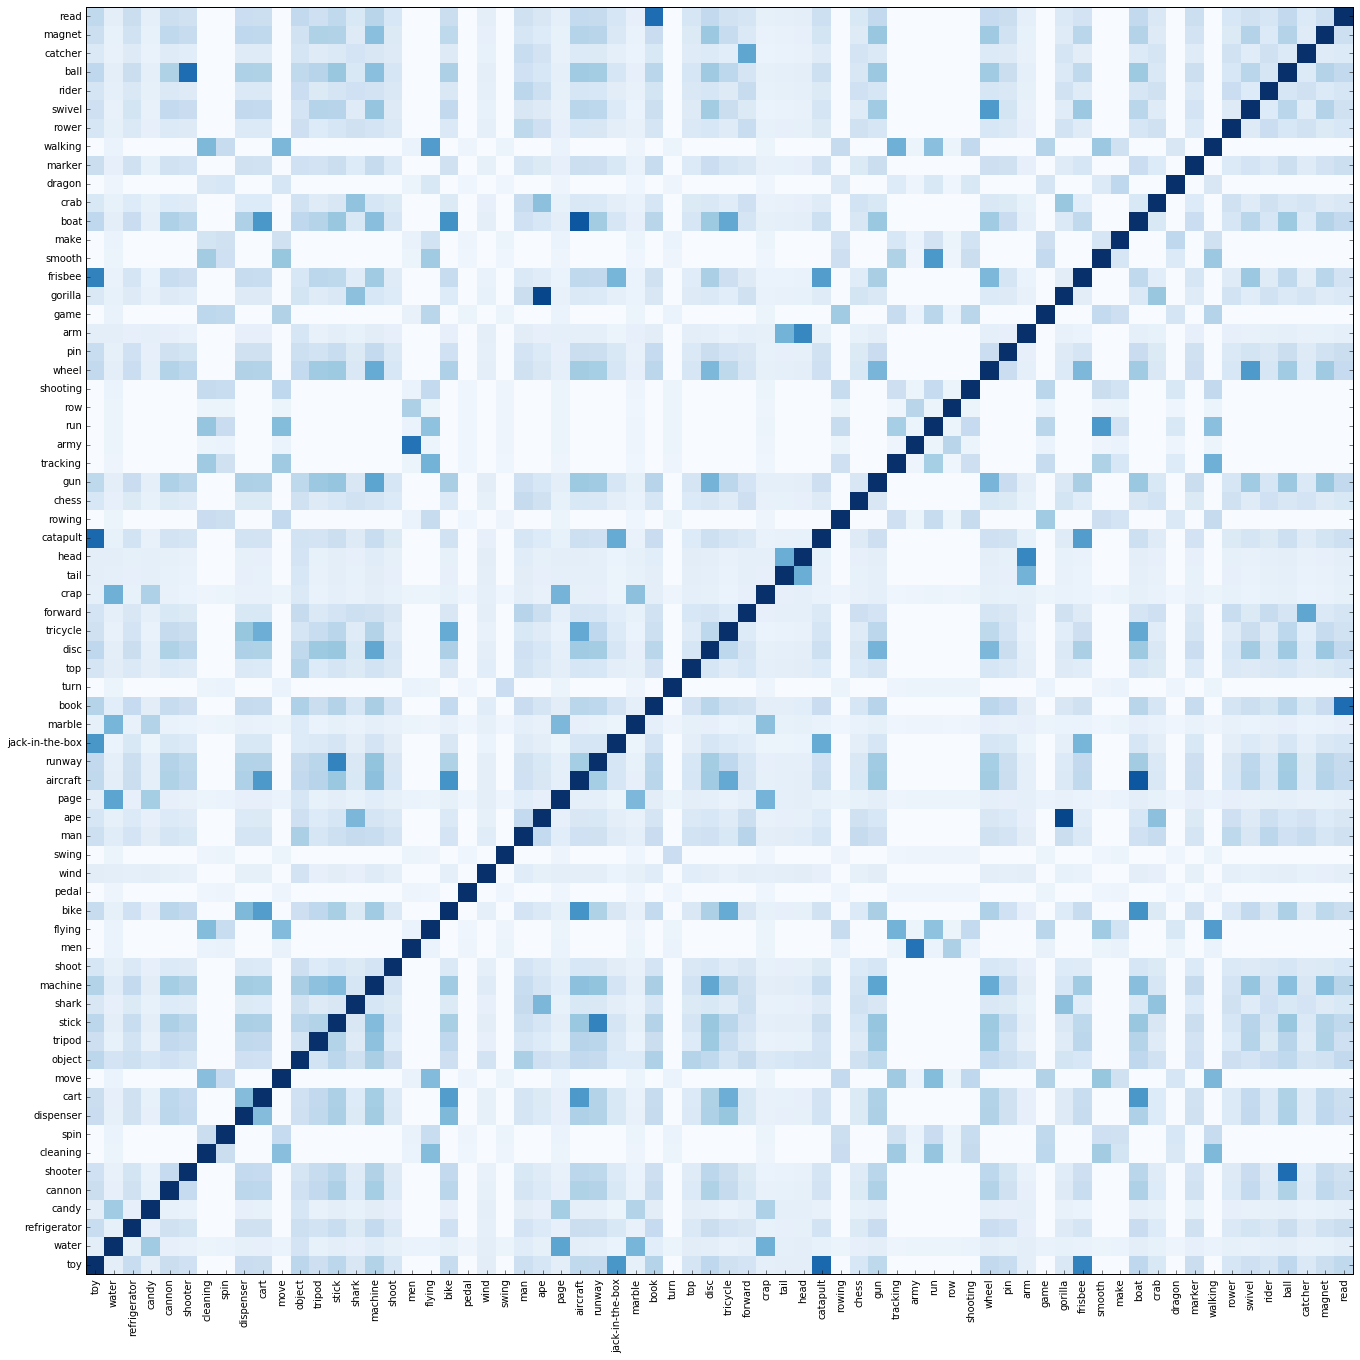

In [11]:
def similarityMat(words, infoCorpus, pos='n'):
    simMatrix = []
    synsets = []
    finalwords = []
    # Identify words for which similarities can be computed. 
    # This excluldes adjectives (a), satellite adjectives (s), and adverbs (r).
    # Also discard words for which synsets do not exist: these words lie outside
    # the WordNet hierarchy.
    for token in words:
        tempSyn = wn.synsets(token)
        if len(tempSyn) > 0 :
            for syn in tempSyn:
                if (set(syn.pos()).intersection(set([pos]))):
                    synsets.append(tempSyn[0])
                    finalwords.append(token)
                    break
        else :
            print("Synset not found for", token)
    print("Number of words in matrix:", len(synsets))
    rowLabels = finalwords
    colLabels = finalwords
    # For the shortlisted words and their corresponding synsets, 
    # identify the semantic similarity (inverse of distance) between
    # every word and every other word.
    for i, synsetLH in enumerate(synsets):
        simRow = []
        for j, synsetRH in enumerate(synsets):
            if synsetLH.pos() == synsetRH.pos() :
                similarity = synsetLH.lin_similarity(synsetRH, infoCorpus)
                if (similarity == -0.0):
                    similarity = 0.0
            else :
                similarity = 0.0
            simRow.append(similarity)
        if i == 0 :
            simMatrix = simRow
        else:
            simMatrix = np.vstack((simMatrix, simRow))
    # Draw the matrix
    fig = pylab.figure(figsize=(20,20))
    ax = fig.add_axes([0.1, 0.1, 0.88, 0.88]) # left, bottom, width, height
    ax.set_xlim(0, len(colLabels))
    ax.set_ylim(0, len(rowLabels))
    simMatrixPlot = ax.pcolor(simMatrix, cmap=plt.cm.Blues)
    ax.xaxis.tick_bottom()
    ax.set_xticks(np.arange(len(colLabels)) + 0.5, minor=False)
    ax.set_xticklabels(colLabels, rotation='vertical', minor=False)
    ax.set_yticks(np.arange(len(rowLabels)) + 0.5, minor=False)
    ax.set_yticklabels(rowLabels, minor=False)
    plt.show(fig)
    return [simMatrix, finalwords, synsets]

outMatrix,outwords, outSynsets = similarityMat(lemmatizedWords, wordnet_ic.ic('ic-bnc-add1.dat'), pos='n')

## 4. Compute hierarchical clusters
Using agglomerative hierarchical clustering, the above matrix can be rearranged hierarchically by identifying pairs of rows that are closest in values to each other, then finding rows that are closet in value to these pairs, and so on until we complete the entire matrix.

method = ward
original matrix size: 68 X 68
length of original word list: 68
['run', 'smooth', 'tracking', 'flying', 'walking', 'cleaning', 'move', 'make', 'dragon', 'rowing', 'game', 'spin', 'shooting', 'jack-in-the-box', 'frisbee', 'toy', 'catapult', 'aircraft', 'boat', 'tricycle', 'cart', 'bike', 'book', 'read', 'shooter', 'ball', 'wheel', 'swivel', 'disc', 'machine', 'gun', 'tripod', 'magnet', 'stick', 'runway', 'cannon', 'dispenser', 'ape', 'gorilla', 'shark', 'crab', 'forward', 'catcher', 'marker', 'refrigerator', 'pin', 'wind', 'shoot', 'top', 'object', 'man', 'chess', 'rower', 'rider', 'row', 'men', 'army', 'pedal', 'swing', 'turn', 'tail', 'head', 'arm', 'candy', 'marble', 'crap', 'water', 'page']
['toy', 'water', 'refrigerator', 'candy', 'cannon', 'shooter', 'cleaning', 'spin', 'dispenser', 'cart', 'move', 'object', 'tripod', 'stick', 'shark', 'machine', 'shoot', 'men', 'flying', 'bike', 'pedal', 'wind', 'swing', 'man', 'ape', 'page', 'aircraft', 'runway', 'jack-in-the-box', 

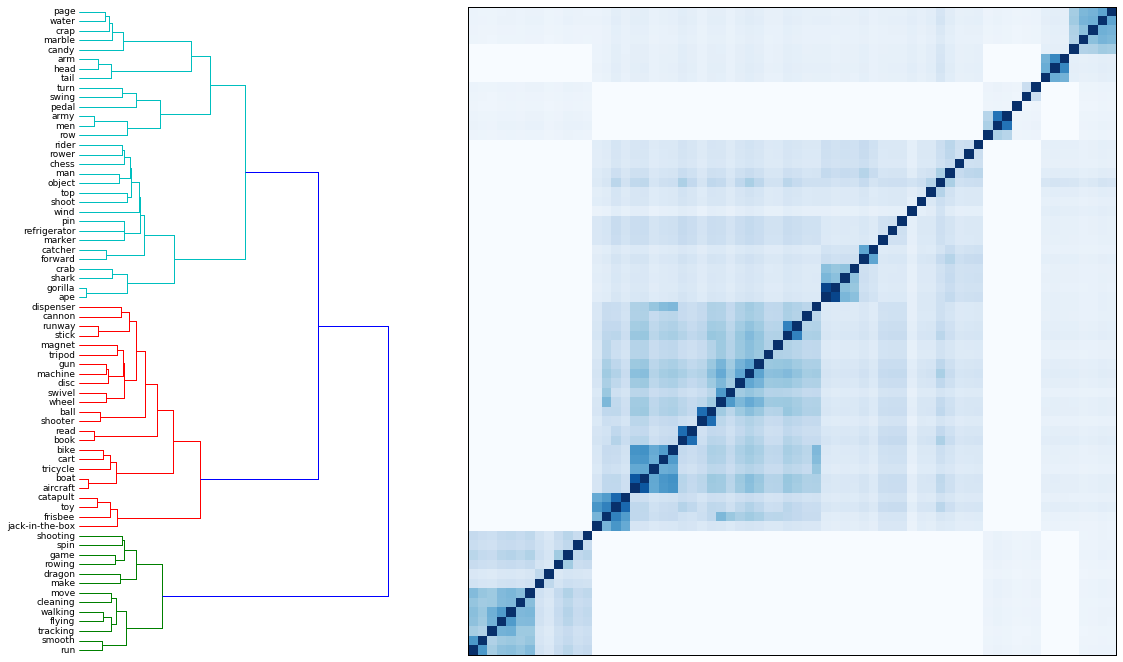

DENDROGRAM IN LIST FORM:
[[[['run', 'smooth'],
   [['tracking', ['flying', 'walking']], ['cleaning', 'move']]],
  [['make', 'dragon'], [['rowing', 'game'], ['spin', 'shooting']]]],
 [[['jack-in-the-box', ['frisbee', ['toy', 'catapult']]],
   [[['aircraft', 'boat'], ['tricycle', ['cart', 'bike']]],
    [['book', 'read'],
     [['shooter', 'ball'],
      [[['wheel', 'swivel'],
        [['disc', ['machine', 'gun']], ['tripod', 'magnet']]],
       [['stick', 'runway'], ['cannon', 'dispenser']]]]]]],
  [[[['ape', 'gorilla'], ['shark', 'crab']],
    [['forward', 'catcher'],
     [['marker', ['refrigerator', 'pin']],
      ['wind',
       [['shoot', 'top'],
        [['object', 'man'], ['chess', ['rower', 'rider']]]]]]]],
   [[['row', ['men', 'army']], ['pedal', ['swing', 'turn']]],
    [['tail', ['head', 'arm']],
     ['candy', ['marble', ['crap', ['water', 'page']]]]]]]]]


In [20]:
# The genTree function is called by the genClusters function. 
# See comments that precede the function call (inside genClusters)
def genTree(treeObj, wordList):
    # generates a list representation from the tree object returned by the
    # linkage function (sch.linkage)
    if treeObj.is_leaf():
        return wordList[treeObj.get_id()]
    else :
        return [genTree(treeObj.get_left(), wordList),
                genTree(treeObj.get_right(), wordList)]

def genTreeNums(treeObj):
    # generates a list representation from the tree object returned by the
    # linkage function (sch.linkage)
    if treeObj.is_leaf():
        return treeObj.get_id()
    else :
        return [genTreeNums(treeObj.get_left()), 
                genTreeNums(treeObj.get_right())]

def get_lch(word1, word2):
    # Given single items from two synset (typically the first one from
    # each), calculate the lowest common hypernyms, and return the first
    # one. This is the same hypernyms that is used for the resnik and lin
    # similarity measures.
    # Note that if the hypernym of synsetItem1 and synsetItem2 is, say,
    # hyp1, then synsetItem1.res_similarity(synsetItem2, brown_ic) gives
    # the same result as synsetItem1.res_similarity(hyp1, brown_ic)
    # We can use this with the results from the agglomerative clustering
    # to find out what hypernyms correspond to all branches in the
    # dendrogram
    synset1 = wn.synsets(word1)
    synset2 = wn.synsets(word2)
    for i, synsetLH in enumerate(synset1):
        for j, synsetRH in enumerate(synset2):
            if (synsetLH.pos() == synsetRH.pos() and not
               set([synsetLH.pos()]).intersection(set(['a','s','r']))):
                hypernymList = synsetLH.lowest_common_hypernyms(synsetRH)
                if len(hypernymList) > 0 :
                    hypernym = hypernymList[0]
                else :
                    print("No hypernym between", synsetLH, "and", synsetRH)
                return hypernym.name().split('.')[0]
    
def getHypernyms(inputList):
    # this takes the dendrogram structure of words in a list format
    # (this format is a list of lists, where each list is a list of either
    # two lists, or a string and a list, or a string and a string.
    # It returns a list which includes hypernyms, so that each list is now
    # a list of three items, the third item being the hypernym of the
    # remaining two.
    if len(inputList) == 2:
        if isinstance(inputList[0], str):
            if isinstance(inputList[1], str):
                tempHyp = str(get_lch(inputList[0], inputList[1]))
                return [tempHyp, inputList[0], inputList[1]]
            else :
                lowerHypList = getHypernyms(inputList[1])
                tempHyp = str(get_lch(inputList[0], lowerHypList[0]))
                return [tempHyp, inputList[0], lowerHypList]
        else :
            lowerHypList1 = getHypernyms(inputList[0])
            lowerHypList2 = getHypernyms(inputList[1])
            tempHyp = str(get_lch(lowerHypList1[0], lowerHypList2[0]))
            return [tempHyp, lowerHypList1, lowerHypList2]
    else : #this means the hypernym list is already computed
        return inputList

def genClusters(simMatrix, words, cMethod, wordSynsetDict):
    # clusters the matrix with the specified method, retrieves the words
    # corresponding to the matrix rows, supplied in a word file
    D1 = simMatrix
    wordsList1 = words
    # refer custom function 'reomveEmptyBands' for details on 
    # what the next line does
    # D, wordsList = removeEmptyBands(D1, wordsList1)
    D, wordsList = D1, wordsList1
    # Output details of the computation
    print('method =', cMethod)
    print('original matrix size:',str(len(D1)),'X',str(len(D1[0]))) 
    print('length of original word list:', str(len(wordsList1)))
    # print('reduced matrix size:',str(len(D)),'X',str(len(D[0]))) 
    # print('length of reduced word list:',str(len(wordsList)))
    
    # First, set up the figure
    fig = pylab.figure(figsize=(15,15))
    # fig.patch.set_visible(False) # plot on transparent background
    ax1 = fig.add_axes([0.01,0.1,0.30,0.6], # left, bottom, width, height
                       {'width':0.05, 
                        'edgecolor':'k',
                        'backgroundcolor':'w'}) 
    # values of left...height are in fractions of figure width & height
    spines_to_remove = ['left', 'bottom', 'right', 'top']
    for spine in spines_to_remove:
        ax1.spines[spine].set_visible(False)
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    # Perform agglomerative clustering by specified method
    Y = sch.linkage(D, method=cMethod)
    # Compute and plot dendrograms
    # This is done twice for row- and column-wise clustering.
    # Note that it is possible to use SEPARATE methods for the
    # rows and columns. This might make for some interesting
    # comparisons later, but for now, let's just consider symmetrical
    # clustering
    Z1 = sch.dendrogram(Y, orientation='right')
    Z2 = sch.dendrogram(Y, orientation='right', labels = wordsList, leaf_font_size=9)
    
    # Plot distance matrix.
    axmatrix = fig.add_axes([0.37,0.1,0.6,0.6])
    idx1 = Z1['leaves']
    idx2 = Z2['leaves']
    D = D[idx1,:]
    D = D[:,idx2]
    im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=pylab.cm.Blues)
    axmatrix.set_xticks([])
    axmatrix.set_yticks([])
    reorderedWords = Z2['ivl']
    print(reorderedWords)
    print(wordsList)
    axmatrix.set_xticklabels(reorderedWords)
    plt.show(fig)
    # generate hypernym tree from dendrogram
    objTree = sch.to_tree(Y, rd=False)
    wordTreeList = genTree(objTree, wordsList)
    wordNumsList = genTreeNums(objTree)
    print("DENDROGRAM IN LIST FORM:")
    pprint.pprint(wordTreeList)
    hypernymsList = getHypernyms(wordTreeList)
    return hypernymsList

hypTree = genClusters(outMatrix, outwords, 'ward', outSynsets)

## 5. Compute hypernyms according to pairs of words in the tree
If you notice carefully, the above list is a nested list of two items at each level. 
These two items are either two words, a word and a list, or two lists. 
We can step through this list recursively every time we encounter two words in a list, and identify the lowest common hypernym for the two.
This means the lowest hypernym in the WordNet hierarchy that subsumes both words.
For instance, **_'person'_** is the lowest common hypernym for **_'rower'_** and **_'shooter'_**.

Happily, we have already calculated the lowest common hypernyms in the function above, so we just need to print it here.
Note that the final list is of the form `[hypernym, word/list 1, word/list 2]` where `list 1` and `list 2` would each have a structure similar to the final list, in a _"turtles, all the way down"_ kind of structure.


In [191]:
print("HYPERNYM TREE CORRESPONDING TO DENDROGRAM:")
pprint.pprint(hypTree, indent=4)

HYPERNYM TREE CORRESPONDING TO DENDROGRAM:
[   'entity',
    [   'psychological_feature',
        [   'psychological_feature',
            ['accomplishment', 'run', 'smooth'],
            [   'psychological_feature',
                ['abstraction', 'tracking', ['motion', 'walking', 'flying']],
                ['action', 'move', 'cleaning']]],
        [   'psychological_feature',
            ['cognition', 'dragon', 'make'],
            [   'event',
                ['activity', 'game', 'rowing'],
                ['event', 'spin', 'shooting']]]],
    [   'entity',
        [   'entity',
            [   'plaything',
                'jack-in-the-box',
                ['plaything', 'frisbee', ['plaything', 'toy', 'catapult']]],
            [   'entity',
                [   'entity',
                    ['craft', 'boat', 'aircraft'],
                    [   'wheeled_vehicle',
                        'tricycle',
                        ['wheeled_vehicle', 'bike', 'cart']]],
                [   

### 5.1. Issues with the above method
The above list of hypernyms has a few issues that need sorting out:
#### 5.1.1. No subsumption assumed in given list
The current implementation assumes that none of the existing words subsumes any of the other words in the list.
This is a serious flaw in the algorithm, and a check like this may need to be performed even before calculating the similarity matrix.
#### 5.1.2. Only nouns in the final matrix
This is fine for now, but losing verbs is a severe loss of meaning, and will need to be addressed.
Note that while _verb troponymy_ exists for WordNet, the *'lowest_common_hypernyms'* method used above will not work, and there doesn't seem to be a function that identifies *'lowest_common_troponyms'* in the NLTK so far.
#### 5.1.3 Only 'common senses' used
We use _"common senses"_ here to mean the sense or meaning of a word that is most common. 
With this, we face the substantial risk of reading a meaning that is different from the meaning intended by the writer (in this case, the team of students).
This issue can only be addressed by user interaction, i.e. allowing the user to select the correct, or most likely, sense of the word.
#### 5.1.x. More issues to be discovered
I'm sure there are other issues, we will uncover them as we iterate.

## 6. To do: Interactive 'slicing' of the dendrogram
The goal of this technique is to use a hierarchical aggregation technique and corresponding semantic term extraction from the WordNet corpus in order to explore the given text through abstraction: getting a sense of the text without going into the details.
This approach has been tried before, in Chris Collins' [_Docuburst_](http://vialab.science.uoit.ca/portfolio/docuburst), and the merits/problems of this work in comparison to Docuburst needs to be explored.
